In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
import numpy as np
import torch
import json
from equistore import Labels, TensorBlock, TensorMap
from torch_builder import TensorBuilder
import ase.io
from itertools import product
from torch_cg import ClebschGordanReal
from torch_hamiltonians import fix_pyscf_l1, dense_to_blocks, blocks_to_dense, couple_blocks, decouple_blocks, hamiltonian_features
import matplotlib.pyplot as plt
from rascal.representations import SphericalExpansion
import copy
import chemiscope
from ase.units import Hartree
torch.set_default_dtype(torch.float64)

In [3]:
import sys
# sys.path.insert(0,'/Users//new-hamiltonian/equistore-examples')
from utils.librascal import  RascalSphericalExpansion, RascalPairExpansion
from utils.acdc_mini import acdc_standardize_keys, cg_increment, cg_combine

In [4]:
frames = ase.io.read("../data/hamiltonian/water-hamiltonian/water_coords_1000.xyz",":100")
for f in frames:
    f.cell = [100,100,100]
    f.positions += 50

In [5]:
import ipywidgets

In [6]:
but = ipywidgets.Button(description="ciao")

In [7]:
but

Button(description='ciao', style=ButtonStyle())

In [8]:
chemiscope.show(frames, mode="structure")

/home/michele/local/lib/python3.8/site-packages/chemiscope/structures.py:305: UserWarning: value '[ 8.210879  0.280605  0.        0.280605  9.429281 -0.        0.
 -0.        8.821933]' of type '<class 'numpy.ndarray'>' for the 'alpha' property from ASE is not convertible to float or string, this property will be ignored.
  warnings.warn(
/home/michele/local/lib/python3.8/site-packages/chemiscope/structures.py:305: UserWarning: value '[0.598465 0.56854  0.      ]' of type '<class 'numpy.ndarray'>' for the 'mu' property from ASE is not convertible to float or string, this property will be ignored.
  warnings.warn(
/home/michele/local/lib/python3.8/site-packages/chemiscope/structures.py:305: UserWarning: value '[ -8.941737  -1.676889  -0.        -1.676889  -2.743205   0.
  -0.         0.        -5.531125  -1.676889  -2.743205   0.
  -2.743205 -13.352259   0.         0.         0.        -3.4944
  -0.         0.        -5.531125   0.         0.        -3.4944
  -5.531125  -3.4944     0.  

StructureWidget(value='{"meta": {"name": " "}, "structures": [{"size": 3, "names": ["O", "H", "H"], "x": [50.0…

In [9]:
#jorbs = json.load(open('data/water-hamiltonian/water_orbs.json', "r"))
jorbs = json.loads(json.load(open('../data/hamiltonian/water-hamiltonian/water_orbs.json', "r")))
orbs = {}
zdic = {"O" : 8, "H":1}
for k in jorbs:
    orbs[zdic[k]] = jorbs[k]

In [10]:
hams = np.load("../data/hamiltonian/water-hamiltonian/water_saph_orthogonal.npy", allow_pickle=True)[:len(frames)]
# NO NEED TO CORRECT L1 ORDER FOR SAPH ORTHOGONALIZED MATRICES...
#for i, f in enumerate(frames):
#    hams[i] = fix_pyscf_l1(hams[i], f, orbs)

In [11]:
cg = ClebschGordanReal(8)

In [12]:
#loss functions
def mse_full(fock, pred_blocks, frame, orbs):
    predicted = blocks_to_dense(decouple_blocks(pred_blocks), frame, orbs)
    mse_loss = torch.empty(len(frame))
    for i in range(len(frame)):
        mse_loss[i] = (torch.linalg.norm(fock[i]-predicted[i]))**2/len(fock[i])
        #print("from mse", i, fock[i], mse_loss[i])
    return torch.mean(mse_loss)*(Hartree)**2

def mse_eigvals(fock, pred_blocks, frame, orbs):
    predicted = blocks_to_dense(decouple_blocks(pred_blocks), frame, orbs)
    evanorm = torch.empty(len(frame))
    for i in range(len(frame)):
        evanorm[i] = torch.mean((torch.linalg.eigvalsh(fock[i]) - torch.linalg.eigvalsh(predicted[i]))**2)/len(fock[i])
    return torch.mean(evanorm)*(Hartree)**2

In [13]:
def normalize_feats(feat, all_blocks=True): 
    all_norm = 0
    for block_idx, block in feat: 
        block_norm = np.linalg.norm(block.values)
#         print(block_idx, block_norm)
        all_norm += block_norm**2
    normalized_blocks=[]
    for block_idx, block in feat: 
        newblock = TensorBlock(
                        values=block.values/np.sqrt(all_norm ),
                        samples=block.samples,
                        components=block.components,
                        properties= block.properties)
                    
        normalized_blocks.append(newblock) 
        
    norm_feat = TensorMap(feat.keys, normalized_blocks)
    return norm_feat

## Manipulate Hamiltonian into blocks

In [14]:
blocks = dense_to_blocks(hams, frames, orbs)
fock_bc = couple_blocks(blocks, cg)

## Feature computation

In [153]:
rascal_hypers = {
    "interaction_cutoff": 2.5,
    "cutoff_smooth_width": 0.5,
    "max_radial": 8,
    "max_angular": 4,
    "gaussian_sigma_constant" : 0.2,
    "gaussian_sigma_type": "Constant",
    "compute_gradients":  False,
}

spex = RascalSphericalExpansion(rascal_hypers)
rhoi = spex.compute(frames)

In [154]:
pairs = RascalPairExpansion(rascal_hypers)
gij = pairs.compute(frames)

In [155]:
rho1i = acdc_standardize_keys(rhoi)
rho1i.keys_to_properties(['species_neighbor'])
gij =  acdc_standardize_keys(gij)

In [156]:
rho2i = cg_increment(rho1i, rho1i, lcut=3, other_keys_match=["species_center"], clebsch_gordan=cg)

In [157]:
#rho3i = cg_increment(rho2i, rho1i, lcut=2, other_keys_match=["species_center"], clebsch_gordan=cg)

In [158]:
rho1ij = cg_increment(rho1i, gij, lcut=3, other_keys_match=["species_center"], clebsch_gordan=cg)

In [159]:
#rho2ij = cg_increment(rho2i, gij, lcut=2, other_keys_match=["species_center"], clebsch_gordan=cg)

In [160]:
ham_feats = hamiltonian_features(rho2i, rho1ij)

In [161]:
norm_ham_feats = normalize_feats(ham_feats)

# Pytorch Model

In [162]:
class LinearModel(torch.nn.Module):
    def __init__(self, coupled_blocks, features, weights=None, intercepts=None):
        super().__init__()
        self.coupled_blocks = coupled_blocks
        self.features = features
        self.weights = {}
        if weights==None:
            for idx_fock, block_fock in self.coupled_blocks:
                block_type, ai, ni, li, aj, nj, lj, L = idx_fock
                parity= (-1)**(li+lj+L)
                size = self.features.block(block_type=block_type, spherical_harmonics_l=L,inversion_sigma=parity, 
                                       species_center=ai, species_neighbor=aj).values.shape[2]
                #self.weights[idx_fock] = torch.nn.Parameter(torch.zeros(size, dtype=torch.float64))
                self.weights[idx_fock] = torch.nn.Parameter(torch.randn(size, dtype=torch.float64))
            
        else: 
            self.weights = weights
        
        self.intercepts = {}
        if intercepts is None:
            for idx_fock, block_fock in self.coupled_blocks:
                block_type, ai, ni, li, aj, nj, lj, L = idx_fock
                parity= (-1)**(li+lj+L)
                if L==0 and parity==1 and block_type==0:
                    self.intercepts[idx_fock] = torch.nn.Parameter(torch.randn(1, dtype=torch.float64))
                else:
                    self.intercepts[idx_fock] = 0
        else:
            self.intercepts = intercepts
         
    def forward(self, features):
        k = []
        pred_blocks = []
        for (idx, wts) in self.weights.items():
            #print(wts)
            block_type, ai, ni, li, aj, nj, lj, L = idx
            k.append(list(idx))
            parity= (-1)**(li+lj+L)
            X = features.block(block_type=block_type, spherical_harmonics_l=L,inversion_sigma=parity, 
                                   species_center=ai, species_neighbor=aj)
            X_new = torch.from_numpy(X.values.reshape(-1, X.values.shape[2]))
            #print(idx, wts.shape, X.values.shape, X_new.shape)
            Y = X_new @ wts + self.intercepts[idx]
            
            newblock = TensorBlock(
                        values=Y.reshape((-1, 2 * L + 1, 1)),
                        samples=X.samples,
                        components=[Labels(
                            ["mu"], np.asarray(range(-L, L + 1), dtype=np.int32).reshape(-1, 1)
                        )],
                        properties= Labels(["values"], np.asarray([[0]], dtype=np.int32))
                    )
            pred_blocks.append(newblock) 
        
        keys = Labels(('block_type', 'a_i', 'n_i', 'l_i', 'a_j', 'n_j', 'l_j', 'L'), np.asarray(k, dtype=np.int32))
        pred_fock = TensorMap(keys, pred_blocks)
        return(pred_fock)
        ### add direct eigenvalue prediction here as well
    
    def parameters(self):
        for idx, wts in self.weights.items():
            yield wts
        for idx, wts in self.intercepts.items():
            if type(wts) is not int:
                yield wts

# For single frame

In [21]:
i_frame = frames[0]
i_ham = hams[0] 

i_feats = ham_feats.slice(Labels(names=["structure"], values=np.asarray(range(1), dtype=np.int32).reshape(-1,1)) )
i_focks = fock_bc.slice(Labels(names=["structure"], values=np.asarray(range(1), dtype=np.int32).reshape(-1,1)) )

In [22]:
norm_i_feats = normalize_feats(i_feats)

### Testing the model with weights from equistore

In [23]:
weights = np.load('model_weights.npy', allow_pickle=True)[()]
intercepts = np.load('model_intercepts.npy', allow_pickle=True)[()]

In [24]:
model = LinearModel(i_focks, i_feats, weights=weights, intercepts=intercepts)
print(f"the model contains {len(list(model.parameters()))} parameters")

pred = model(i_feats)

the model contains 8 parameters


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 256 is different from 5184)

In [ ]:
loss = mse_full([torch.from_numpy(i_ham.astype(np.float64))], pred, [i_frame], orbs)
print(torch.sqrt(loss))

### Training with loss on full Hamiltonian

In [ ]:
model = LinearModel(i_focks, norm_i_feats)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15000, gamma=0.01)

all_losses = []
for epoch in range(3000):
    optimizer.zero_grad()
    pred = model(norm_i_feats)
    loss = mse_full([torch.from_numpy(i_ham.astype(np.float64))], pred, [i_frame], orbs)
    loss.backward()
    
    optimizer.step()
#     scheduler.step()
    
    all_losses.append(loss.item())

    if epoch % 500 == 0:
        print(epoch, loss.item())

In [ ]:
plt.loglog(all_losses)

plt.xlabel("epochs")
plt.ylabel("$MSE_{full}$")

In [ ]:
pred = model(norm_i_feats)
mse_full([torch.from_numpy(i_ham.astype(np.float64))], pred, [i_frame], orbs)

### Training with loss on eigenvalues

In [ ]:
model = LinearModel(i_focks, i_feats)
optimizer = torch.optim.Adam(model.parameters(), lr=0.8)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.01)

eigval_losses = []
for epoch in range(30000):
    optimizer.zero_grad()
    pred = model(i_feats[0])
    eigval_loss = mse_eigvals([torch.from_numpy(i_ham.astype(np.float64))], pred, [i_frame], orbs)
    eigval_loss.backward()
    optimizer.step()
    
    eigval_losses.append(eigval_loss.item())

    if epoch % 1000 == 0:
        print(epoch, eigval_loss.item())
    
    scheduler.step()

In [ ]:
plt.loglog(eigval_losses)

plt.xlabel("epochs")
plt.ylabel("$MSE_{\epsilon}$")

In [ ]:
pred_coupled = model(ham_feats)
rmse_full = torch.sqrt(mse_full([torch.from_numpy(i_ham.astype(np.float64))], pred, [i_frame], orbs))
print(rmse_full)

# Train and test on multiple frames

### Split into train and test set

In [163]:
N=len(frames)
ntrain = int(N*0.8)
train_frames = frames[:ntrain]
train_hams = hams[:ntrain]
train_feats = norm_ham_feats.slice(Labels(names=["structure"], values=np.asarray(range(ntrain), dtype=np.int32).reshape(-1,1)) )
train_focks = fock_bc.slice(Labels(names=["structure"], values=np.asarray(range(ntrain), dtype=np.int32).reshape(-1,1)) )

In [164]:
test_frames = frames[ntrain:N]
test_hams = hams[ntrain:N]
test_feats = norm_ham_feats.slice(Labels(names=["structure"], values=np.asarray(range(ntrain,N), dtype=np.int32).reshape(-1,1)) )
test_focks = fock_bc.slice(Labels(names=["structure"], values=np.asarray(range(ntrain,N), dtype=np.int32).reshape(-1,1)) )

## Train on Hamiltonian target

In [26]:
model = LinearModel(train_focks, train_feats)
optimizer = torch.optim.Adam(model.parameters(), lr=0.8)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.8)

all_losses = []
for epoch in range(5000):
    optimizer.zero_grad()
    pred = model(train_feats)
    loss = mse_full(torch.from_numpy(train_hams.astype(np.float64)), pred, train_frames, orbs)
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    all_losses.append(loss.item())
    
    if epoch % 50 == 0:
        print(epoch, loss.item()) 
#     if loss.item <1e-15: 
#         break 

0 326.60009765625
50 0.5482138991355896


KeyboardInterrupt: 

In [ ]:
model = LinearModel(train_focks, train_feats)
optimizer = torch.optim.LBFGS(
        model.parameters(),
        lr=0.8,  line_search_fn="strong_wolfe",
        history_size=256,
    )

In [29]:
all_losses = []
for epoch in range(300):
    def single_step():
        optimizer.zero_grad()
        pred = model(train_feats)
        loss = mse_full(torch.from_numpy(train_hams.astype(np.float64)), pred, train_frames, orbs)
        loss.backward()
        return loss
    
    loss = optimizer.step(single_step)
    
    all_losses.append(loss.item())
    
    if epoch % 1 == 0:
        print(epoch, loss.item()) 
#     if loss.item <1e-15: 
#         break 

NameError: name 'optimizer' is not defined

In [ ]:
plt.loglog(np.sqrt(all_losses))

plt.xlabel("epochs")
plt.ylabel("$RMSE_{full}$")
print(np.sqrt(all_losses[-1]), "eV rmse on TRAIN H prediction")

In [ ]:
pred_all = model(norm_ham_feats.slice(Labels(names=["structure"], values=np.asarray(range(N), dtype=np.int32).reshape(-1,1)) ))
all_loss = mse_full(torch.from_numpy(hams[:N].astype(np.float64)), pred_all, frames[:N], orbs)
print(torch.sqrt(all_loss), "eV rmse on ALL H prediction")
# test_loss_eigvals = mse_eigvals(torch.from_numpy(test_hams.astype(np.float64)), pred_test, test_frames, orbs)

In [ ]:
###TEMPORARY FIX to reindex just the test frames 
pred_test = model(test_feats)
bvalues = []
for i, b in pred_test:
    newblock = TensorBlock(
                        values=b.values,
                        samples=pred.block(i).samples[:len(b.values)],
                        components=b.components,
                        properties= b.properties)
                    
    bvalues.append(newblock) 
        
reindexed_pred_test  = TensorMap(test_focks.keys, bvalues)

In [ ]:
# reindexed_pred_test.block(0).samples

In [ ]:
test_loss = mse_full(torch.from_numpy(test_hams.astype(np.float64)), reindexed_pred_test, test_frames, orbs)
test_loss_eigvals = mse_eigvals(torch.from_numpy(test_hams.astype(np.float64)), reindexed_pred_test, test_frames, orbs)
print(torch.sqrt(test_loss),  "eV rmse on TEST H prediction")
print(torch.sqrt(test_loss_eigvals),  "eV rmse on TEST eigen prediction")

## Training on eigenvalue loss

In [165]:
model = LinearModel(train_focks, train_feats)

In [166]:
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.5)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.1)
optimizer = torch.optim.LBFGS(
        model.parameters(),
        lr=0.1,  line_search_fn="strong_wolfe",
        history_size=256, tolerance_grad=1e-12, tolerance_change=1e-12
    )

manual gradient check

In [179]:
eva_loss = 0
full_loss = 0
def single_step():
    global eva_loss, full_loss
    optimizer.zero_grad()
    pred = model(train_feats)
    eva_loss = mse_eigvals(torch.from_numpy(train_hams.astype(np.float64)), pred, train_frames, orbs)
    full_loss = mse_full(torch.from_numpy(train_hams.astype(np.float64)), pred, train_frames, orbs)
    loss_combined = 1e0*eva_loss + 1e-4*full_loss
    loss_combined.backward()
    return loss_combined

In [180]:
all_eigval_losses = []
all_losses = []
combined_loss = []
for epoch in range(100):  
    loss_combined = optimizer.step(single_step)
    #scheduler.step()
    
    all_eigval_losses.append(eva_loss.item())
    all_losses.append(full_loss.item())
    combined_loss.append(loss_combined.item())
    
    if epoch % 1== 0:
        print(epoch, loss_combined.item(), np.sqrt(eva_loss.item()), np.sqrt(full_loss.item()))
        if epoch % 5== 0:
            print("gradients") 
            for k, w in model.weights.items():  
                print(k, np.linalg.norm(w.grad))

0 5.856097496969554e-06 0.0023511937761550045 0.01510000256027047
gradients
(0, 8, 2, 0, 8, 2, 0, 0) 4.9708047879814025e-06
(0, 8, 2, 0, 8, 2, 1, 1) 1.1284339893058139e-05
(0, 8, 2, 1, 8, 2, 1, 0) 4.509364647334141e-06
(0, 8, 2, 1, 8, 2, 1, 2) 3.468839575788039e-06
(2, 1, 1, 0, 8, 2, 0, 0) 1.4027248645832418e-06
(2, 1, 1, 0, 8, 2, 1, 1) 9.147812118975273e-06
(0, 1, 1, 0, 1, 1, 0, 0) 1.0373503071430188e-05
(1, 1, 1, 0, 1, 1, 0, 0) 5.633418086214473e-07
1 5.550913180762047e-06 0.002239991010547779 0.02730472513799641
2 5.092114528821015e-06 0.0021852577389186237 0.03241019362751727
3 4.880393450601051e-06 0.0021580257133496524 0.03400242230656714
4 4.77269145174969e-06 0.002100450855553198 0.037777729854792885
5 4.554609483892332e-06 0.0020642800603616223 0.04206037543065555
gradients
(0, 8, 2, 0, 8, 2, 0, 0) 1.4579176818002023e-06
(0, 8, 2, 0, 8, 2, 1, 1) 9.826346988086403e-07
(0, 8, 2, 1, 8, 2, 1, 0) 7.467255843833045e-07
(0, 8, 2, 1, 8, 2, 1, 2) 1.0390476557712937e-06
(2, 1, 1, 0, 8, 

Text(0, 0.5, '$RMSE_{\\epsilon}$')

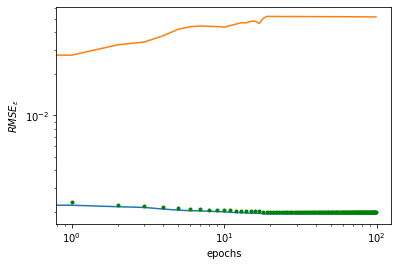

In [181]:
plt.loglog(np.sqrt(all_eigval_losses))
plt.loglog(np.sqrt(all_losses))
plt.loglog(np.sqrt(combined_loss), 'g.')

plt.xlabel("epochs")
plt.ylabel("$RMSE_{\epsilon}$")

In [182]:
pred_test = model(test_feats)
bvalues = []
for i, b in pred_test:
    newblock = TensorBlock(
                        values=b.values,
                        samples=pred.block(i).samples[:len(b.values)],
                        components=b.components,
                        properties= b.properties)
                    
    bvalues.append(newblock) 
        
reindexed_pred_test  = TensorMap(test_focks.keys, bvalues)

In [183]:
dense = blocks_to_dense(decouple_blocks(reindexed_pred_test), test_frames, orbs)

In [184]:
torch.linalg.eigvalsh(torch.from_numpy(test_hams[13]))

tensor([-1.3969, -0.6683, -0.6192, -0.5151,  0.1617,  0.2686])

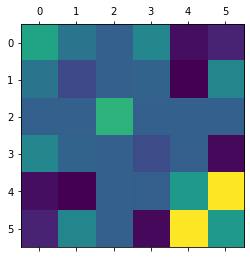

In [185]:
plt.matshow(dense[13].detach().numpy() - test_hams[13])

In [186]:
print(torch.linalg.eigvalsh(torch.from_numpy(test_hams[13])))
print(torch.linalg.eigvalsh(dense[13]) )

tensor([-1.3969, -0.6683, -0.6192, -0.5151,  0.1617,  0.2686])
tensor([-1.3904, -0.6671, -0.6154, -0.5051,  0.1875,  0.2485],
       grad_fn=<LinalgEighBackward0>)


In [188]:
for i in range(20):
    print(torch.mean(torch.abs((torch.linalg.eigvalsh(dense[i]) - torch.linalg.eigvalsh(torch.from_numpy(test_hams[i]))) * Hartree )))

tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0143, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0097, grad_fn=<MeanBackward0>)
tensor(0.0157, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0226, grad_fn=<MeanBackward0>)
tensor(0.0072, grad_fn=<MeanBackward0>)
tensor(0.0081, grad_fn=<MeanBackward0>)
tensor(0.0518, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0014, grad_fn=<MeanBackward0>)
tensor(0.3062, grad_fn=<MeanBackward0>)
tensor(0.0147, grad_fn=<MeanBackward0>)
tensor(0.0099, grad_fn=<MeanBackward0>)
tensor(0.0062, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0014, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)


In [187]:
test_loss = mse_full(torch.from_numpy(test_hams.astype(np.float64)), reindexed_pred_test, test_frames, orbs)
test_loss_eigvals = mse_eigvals(torch.from_numpy(test_hams.astype(np.float64)), reindexed_pred_test, test_frames, orbs)
print(torch.sqrt(test_loss),  "eV rmse on TEST H prediction")
print(torch.sqrt(test_loss_eigvals),  "eV rmse on TEST eigen prediction")

tensor(0.1193, grad_fn=<SqrtBackward0>) eV rmse on TEST H prediction
tensor(0.0363, grad_fn=<SqrtBackward0>) eV rmse on TEST eigen prediction


In [152]:
chemiscope.show(test_frames, mode="structure")

StructureWidget(value='{"meta": {"name": " "}, "structures": [{"size": 3, "names": ["O", "H", "H"], "x": [50.0…

In [52]:
chemiscope.show(train_frames, mode="structure")

StructureWidget(value='{"meta": {"name": " "}, "structures": [{"size": 3, "names": ["O", "H", "H"], "x": [50.0…

## Train first on MSE_full and then retrain on MSE_eigenvalues

In [ ]:
model = LinearModel(train_focks, train_feats)
optimizer = torch.optim.Adam(model.parameters(), lr=0.8)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.1)

all_losses = []
for epoch in range(3000):
    optimizer.zero_grad()
    pred = model(train_feats)
    loss = mse_full(torch.from_numpy(train_hams.astype(np.float64)), pred, train_frames, orbs)
    loss.backward()
    optimizer.step()
    #scheduler.step()
    
    all_losses.append(loss.item())
    
    if epoch % 100 == 0:
        print(epoch, loss.item()) 

In [ ]:
all_eigval_losses = []
all_ham_losses = []
combined_loss = []

for epoch in range(3000):
    optimizer.zero_grad()
    re_pred = model(train_feats)
    loss1 = mse_full(torch.from_numpy(train_hams.astype(np.float64)), re_pred, train_frames, orbs)
    loss2 = mse_eigvals(torch.from_numpy(train_hams.astype(np.float64)), re_pred, train_frames, orbs)
    loss_combined = loss1 + loss2
    loss_combined.backward()
    optimizer.step()
    #scheduler.step()
    
    all_eigval_losses.append(loss2.item())
    all_ham_losses.append(loss1.item())
    combined_loss.append(loss_combined.item())
    
    if epoch % 500 == 0:
        print("Epoch:", epoch, "combined:", loss_combined.item(), "MSE_full:", loss1.item(), "MSE_eva:", loss2.item())

In [ ]:
pred_test = model(test_feats)
bvalues = []
for i, b in pred_test:
    newblock = TensorBlock(
                        values=b.values,
                        samples=pred.block(i).samples[:len(b.values)],
                        components=b.components,
                        properties= b.properties)
                    
    bvalues.append(newblock) 
        
reindexed_pred_test  = TensorMap(test_focks.keys, bvalues)

In [ ]:
test_loss = mse_full(torch.from_numpy(test_hams.astype(np.float64)), reindexed_pred_test, test_frames, orbs)
test_loss_eigvals = mse_eigvals(torch.from_numpy(test_hams.astype(np.float64)), reindexed_pred_test, test_frames, orbs)
print(torch.sqrt(test_loss),  "eV rmse on TEST H prediction")
print(torch.sqrt(test_loss_eigvals),  "eV rmse on TEST eigen prediction")

In [182]:
chemiscope.show(test_frames, mode="structure")

StructureWidget(value='{"meta": {"name": " "}, "structures": [{"size": 3, "names": ["O", "H", "H"], "x": [50.0…